# Image Classification

This code shows how images, specifically vehicle images like cars, trucks, vans, bikes, motorcycles and others, can be classified using Convolutional Neural Network (CNN). This code is built based on an image classifier developed for the "Applied Data Science: Machine Learning" Program from the EPFL Lausanne.
The dataset consists of Swissroads data set which contains several hundreds images of vehicles found in the EPFL - Lausanne area including cars, trucks, vans, bikes, motorcycles and others. The dataset is quite small, hence the results, but could easily be extended to include other datasets and other vehicles classes.

In [1]:
# filter warnings
import warnings
warnings.simplefilter(action="ignore")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# keras imports
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras import backend as K 


import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import glob
import random
import re

import cv2
from PIL import Image

In [2]:
BATCH_SIZE = 16
EPOCHS = 500
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 6
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
LEARNING_RATE = 1e-4

In [3]:
base_dir = os.getcwd()  # Get the current working directory
data_dir = os.path.join(base_dir, 'swissroads')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
valid_dir = os.path.join(data_dir, 'valid')

***
**Utility functions**
***

In [4]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], color = colors[n], label = 'Train ' + label)
    plt.semilogy(history.epoch,  history.history['val_loss'], color = colors[n], label = 'Val ' + label, linestyle = "--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

In [6]:
def plot_accuracy(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['accuracy'], color = colors[n], label = 'Train ' + label)
    plt.semilogy(history.epoch,  history.history['val_accuracy'], color = colors[n], label = 'Val ' + label, linestyle = "--")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
  
    plt.legend()

In [7]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch,  history.history[metric], color = colors[0], label = 'Train')
        plt.plot(history.epoch, history.history['val_' + metric], color = colors[1], linestyle = "--", label = 'Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])
        plt.legend()

In [8]:
colorspaces = ['bgr', 'hsv', 'yuv', 'crcb', 'hls', 'lab', 'luv', 'xyz']

***
**Standardizing the data**
***
Our image are already in a standard size (256x256), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general we should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

In [9]:
# apply data augmentation to improve overfitting
train_image_generator = ImageDataGenerator(rescale = 1./255) # Generator for our training data

In [10]:
# only rescale, as we want our model to predict on real world images
validation_image_generator = ImageDataGenerator(rescale = 1./255) # Generator for our validation data
test_image_generator = ImageDataGenerator(rescale = 1./255) # Generator for our test data

***
**Data pre-processing**
***
In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. This class allows to:

- configure random transformations and normalization operations to be done on your image data during training
- instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.

In [11]:
train_data_gen = train_image_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                           directory = train_dir,
                                                           shuffle = True,
                                                           target_size = IMG_SIZE,
                                                           class_mode = 'categorical')

Found 280 images belonging to 6 classes.


In [12]:
valid_data_gen = validation_image_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                           directory = valid_dir,
                                                           shuffle = True,
                                                           target_size = IMG_SIZE,
                                                           class_mode = 'categorical')

Found 139 images belonging to 6 classes.


In [13]:
test_data_gen = test_image_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                           directory = test_dir,
                                                           shuffle = True,
                                                           target_size = IMG_SIZE,
                                                           class_mode = 'categorical')

Found 50 images belonging to 6 classes.


This part is to check the data format i.e if the RGB channel is coming first or last so that whatever it may be, the model will first check and then get the appropriate input shape be fed accordingly.

In [14]:
if K.image_data_format() == 'channels_first': 
    input_shape = (3, IMG_WIDTH, IMG_HEIGHT) 
else: 
    input_shape = (IMG_WIDTH, IMG_HEIGHT, 3) 

***
**Build the model**
***

The right tool for an image classification job is a convnet, so let's try to train one on our data, as an initial baseline. Since we only have few examples, our number one concern should be overfitting. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three, images of people who are sailors, and among them only one lumberjack wears a cap, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Data augmentation is one way to fight overfitting, but it isn't enough since our augmented samples are still highly correlated. Your main focus for fighting overfitting should be the entropic capacity of your model --how much information your model is allowed to store. A model that can store a lot of information has the potential to be more accurate by leveraging more features, but it is also more at risk to start storing irrelevant features. Meanwhile, a model that can only store a few features will have to focus on the most significant features found in the data, and these are more likely to be truly relevant and to generalize better.

There are different ways to modulate entropic capacity. The main one is the choice of the number of parameters in the model, i.e. the number of layers and the size of each layer. Another way is the use of weight regularization, such as L1 or L2 regularization, which consists in forcing model weights to taker smaller values.


The architectural decisions we will be making are the number of layers, the number of filters, and the size of the filters. In our case we will use a rather small convnet with few layers and few filters per layer, alongside data augmentation and dropout. Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation (you could say that both dropout and data augmentation tend to disrupt random correlations occuring in the data). 

This is very similar to the architectures that Yann LeCun advocated in the 1990s for image classification (with the exception of ReLU).

- **Conv2D** is the layer to convolve the image into multiple images
- **Activation** is the activation function.
- **MaxPooling2D** is used to max pool the value from the given size matrix and same is used for the next 2 layers. then, Flatten is used to flatten the dimensions of the image obtained after convolving it.
- **Dense** is used to make this a fully connected model and is the hidden layer.
- **Dropout** is used to avoid overfitting on the dataset.
- **Dense** is the output layer contains only one neuron which decide to which category image belongs.

Typically the number of layers starts small and grows as the complexity realized by the convoluted layers grows. The number of filters in a layer should be set at ratios of 32, 64, 128, 256, 512 and so on according to one source. In this case I have elected to make four convolutional layers with succeeding filter sizes of 32, 64, 128, and 256.

Filters have odd values since they need to be centered on the pixel being convolved. A 3x3 filter is usual although larger ones of 5x5 up to 7x7 may work better on larger images. Max pool layers typically have a pool size of (2, 2) and are applied after each convolutional layer.

After flattening I chose to set dropout to 0.3. 

The model was given a single dense layer with 512 neurons with activation set to 'relu' as usual. The number of output elements is always set to the number of classes and activation to 'softmax'.

***
**Model Architecture**
***

In [15]:
def make_model():
        
    model = Sequential()

    model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = input_shape))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(256, (3, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(NUM_CLASSES, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = LEARNING_RATE), metrics = ['accuracy'])

    return model

In [17]:
# import PIL.Image as Image
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# im = Image.open('model_plot.png')
# im

**Early stopping**

When we’re training a learning algorithm iteratively, we can measure how well each iteration of the model performs. Up until a certain number of iterations, new iterations improve the model. After that point, however, the model’s ability to generalize can weaken as it begins to overfit the training data. Early stopping refers stopping the training process before the learner passes that point.

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy', 
    verbose = 2,
    patience = 20,
    min_delta = 0.001, 
    mode = 'max',
    restore_best_weights = True)

In [19]:
callbacks = [early_stopping]

***
**Train the model**
***

In [20]:
TRAIN_STEPS = int(np.ceil(train_data_gen.n / float(BATCH_SIZE)))

In [21]:
VALIDATION_STEPS = int(np.ceil(valid_data_gen.n / float(BATCH_SIZE)))

In [22]:
TEST_STEPS = int(np.ceil(test_data_gen.n / float(BATCH_SIZE)))

In [16]:
model = make_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       2

In [23]:
history = model.fit( 
    train_data_gen, 
    steps_per_epoch = TRAIN_STEPS, 
    epochs = EPOCHS,
    callbacks = callbacks, 
    validation_data = valid_data_gen, 
    validation_steps = VALIDATION_STEPS
)

Epoch 1/500
18/18 [==============================] - 50s 3s/step - loss: 1.7890 - accuracy: 0.2018 - val_loss: 1.7426 - val_accuracy: 0.1799
Epoch 2/500
18/18 [==============================] - 54s 3s/step - loss: 1.7233 - accuracy: 0.3030 - val_loss: 1.6770 - val_accuracy: 0.3957
Epoch 3/500
18/18 [==============================] - 42s 2s/step - loss: 1.6026 - accuracy: 0.4876 - val_loss: 1.5310 - val_accuracy: 0.4173
Epoch 4/500
18/18 [==============================] - 46s 3s/step - loss: 1.4460 - accuracy: 0.4745 - val_loss: 1.4354 - val_accuracy: 0.4317
Epoch 5/500
18/18 [==============================] - 44s 2s/step - loss: 1.1290 - accuracy: 0.6080 - val_loss: 1.3235 - val_accuracy: 0.5396
Epoch 6/500
18/18 [==============================] - 39s 2s/step - loss: 0.9367 - accuracy: 0.6544 - val_loss: 1.3819 - val_accuracy: 0.4676
Epoch 7/500
18/18 [==============================] - 38s 2s/step - loss: 0.7164 - accuracy: 0.7696 - val_loss: 1.3268 - val_accuracy: 0.4748
Epoch 8/500
1

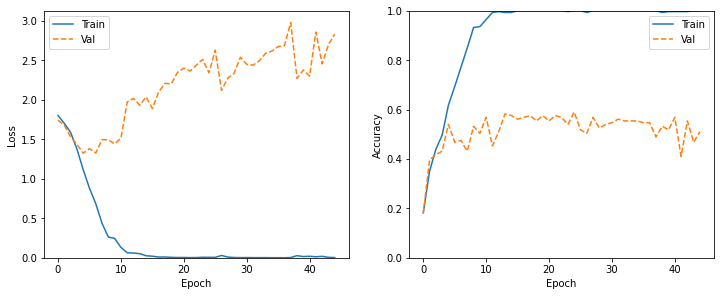

In [24]:
plot_metrics(history)

The model is clearly overfitting so let's see if augmenting the data by using different color space transformations will improve the model.

In [26]:
# evaluate model on validation data
score = model.evaluate(valid_data_gen, steps = VALIDATION_STEPS, verbose = 2)

9/9 - 5s - loss: 2.3414 - accuracy: 0.5899


In [27]:
print(f'Validation loss: {score[0]} / Validation accuracy: {score[1]}')

Validation loss: 2.3413829803466797 / Validation accuracy: 0.5899280309677124


In [28]:
# evaluate model on test data
score = model.evaluate(test_data_gen, steps = TEST_STEPS, verbose = 2)

4/4 - 1s - loss: 3.1069 - accuracy: 0.4600


In [29]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 3.106907844543457 / Test accuracy: 0.46000000834465027


In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [31]:
predictions = model.predict_generator(test_data_gen, steps = TEST_STEPS)

In [33]:
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

In [35]:
# Get ground-truth classes and class-labels
true_classes = test_data_gen.classes
class_labels = list(test_data_gen.class_indices.keys())   

In [36]:
report = classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

        bike       0.27      0.33      0.30        12
         car       0.11      0.09      0.10        11
  motorcycle       0.00      0.00      0.00         9
       other       0.00      0.00      0.00         6
       truck       0.00      0.00      0.00         7
         van       0.25      0.20      0.22         5

    accuracy                           0.12        50
   macro avg       0.10      0.10      0.10        50
weighted avg       0.11      0.12      0.12        50



In [38]:
matrix = confusion_matrix(test_data_gen.classes, predicted_classes)
print(matrix)

[[4 1 5 1 0 1]
 [5 1 1 1 1 2]
 [3 4 0 1 1 0]
 [2 0 4 0 0 0]
 [0 1 4 2 0 0]
 [1 2 1 0 0 1]]


In [40]:
model.save("cnn_no_opt.h5")
print("Saved model to disk")

Saved model to disk


In [42]:
from keras.models import load_model
# load, no need to initialize the loaded model
loaded_model = load_model('cnn_no_opt.h5')

In [43]:
total_train = glob.glob(train_dir + '/**/*.png', recursive=True)
total_valid = glob.glob(valid_dir + '/**/*.png', recursive=True)

In [50]:
history = []

for c in colorspaces:
    print('Run transformation: ' + c)

    model = make_model()
    
    def cspace_transf(image):
        image = np.array(image)
        if c == 'bgr':
            return cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
        elif c == 'hsv':
            return cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
        elif c == 'yuv':
            return cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
        elif c =='crcb':
            return cv2.cvtColor(image,cv2.COLOR_RGB2CrCB)
        elif c == 'hls':
            return cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
        elif c == 'lab':
            return cv2.cvtColor(image,cv2.COLOR_RGB2Lab)
        elif c == 'luv':
            return cv2.cvtColor(image,cv2.COLOR_RGB2Luv)
        elif c == 'xyz':
            return cv2.cvtColor(image,cv2.COLOR_RGB2XYZ)
        else:
            return image
    
    train_data_generator = ImageDataGenerator(rescale = 1./255, preprocessing_function = cspace_transf)
    train_data_gen = train_image_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                           directory = train_dir,
                                                           shuffle = True,
                                                           target_size = IMG_SIZE,
                                                           class_mode = 'categorical') 
    history.append(model.fit(
                  train_data_gen,
                  steps_per_epoch = TRAIN_STEPS,
                  epochs = 30,
#                   callbacks = callbacks, 
                  validation_data = valid_data_gen,
                  validation_steps = VALIDATION_STEPS
                  ))

Run transformation: bgr
Found 280 images belonging to 6 classes.
Epoch 1/30
18/18 [==============================] - 34s 2s/step - loss: 1.8252 - accuracy: 0.1572 - val_loss: 1.7361 - val_accuracy: 0.3022
Epoch 2/30
18/18 [==============================] - 31s 2s/step - loss: 1.7107 - accuracy: 0.3214 - val_loss: 1.6616 - val_accuracy: 0.3453
Epoch 3/30
18/18 [==============================] - 31s 2s/step - loss: 1.5841 - accuracy: 0.4590 - val_loss: 1.5155 - val_accuracy: 0.4388
Epoch 4/30
18/18 [==============================] - 31s 2s/step - loss: 1.3708 - accuracy: 0.5153 - val_loss: 1.4819 - val_accuracy: 0.4748
Epoch 5/30
18/18 [==============================] - 31s 2s/step - loss: 1.2626 - accuracy: 0.5710 - val_loss: 1.4865 - val_accuracy: 0.3957
Epoch 6/30
18/18 [==============================] - 31s 2s/step - loss: 1.0836 - accuracy: 0.6026 - val_loss: 1.3734 - val_accuracy: 0.4532
Epoch 7/30
18/18 [==============================] - 31s 2s/step - loss: 0.8443 - accuracy: 0.68

18/18 [==============================] - 38s 2s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.4402 - val_accuracy: 0.5324
Epoch 26/30
18/18 [==============================] - 39s 2s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 2.6795 - val_accuracy: 0.5468
Epoch 27/30
18/18 [==============================] - 42s 2s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 2.4700 - val_accuracy: 0.5180
Epoch 28/30
18/18 [==============================] - 39s 2s/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 2.5105 - val_accuracy: 0.5396
Epoch 29/30
18/18 [==============================] - 44s 2s/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 2.5208 - val_accuracy: 0.5252
Epoch 30/30
18/18 [==============================] - 43s 2s/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 2.4523 - val_accuracy: 0.5396
Run transformation: hls
Found 280 images belonging to 6 classes.
Epoch 1/30
18/18 [==============================] - 40s 2s/step - loss: 1.7843 - accuracy: 0.2305 - v

18/18 [==============================] - 45s 3s/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.3335 - val_accuracy: 0.5468
Epoch 20/30
18/18 [==============================] - 44s 2s/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 2.2981 - val_accuracy: 0.5827
Epoch 21/30
18/18 [==============================] - 45s 3s/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 2.3385 - val_accuracy: 0.5827
Epoch 22/30
18/18 [==============================] - 46s 3s/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 2.4542 - val_accuracy: 0.5827
Epoch 23/30
18/18 [==============================] - 45s 3s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.4890 - val_accuracy: 0.5755
Epoch 24/30
18/18 [==============================] - 41s 2s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 2.5301 - val_accuracy: 0.5612
Epoch 25/30
18/18 [==============================] - 45s 2s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 2.4666 - val_accuracy: 0.5755
Epoch 26/30
18/18 [======

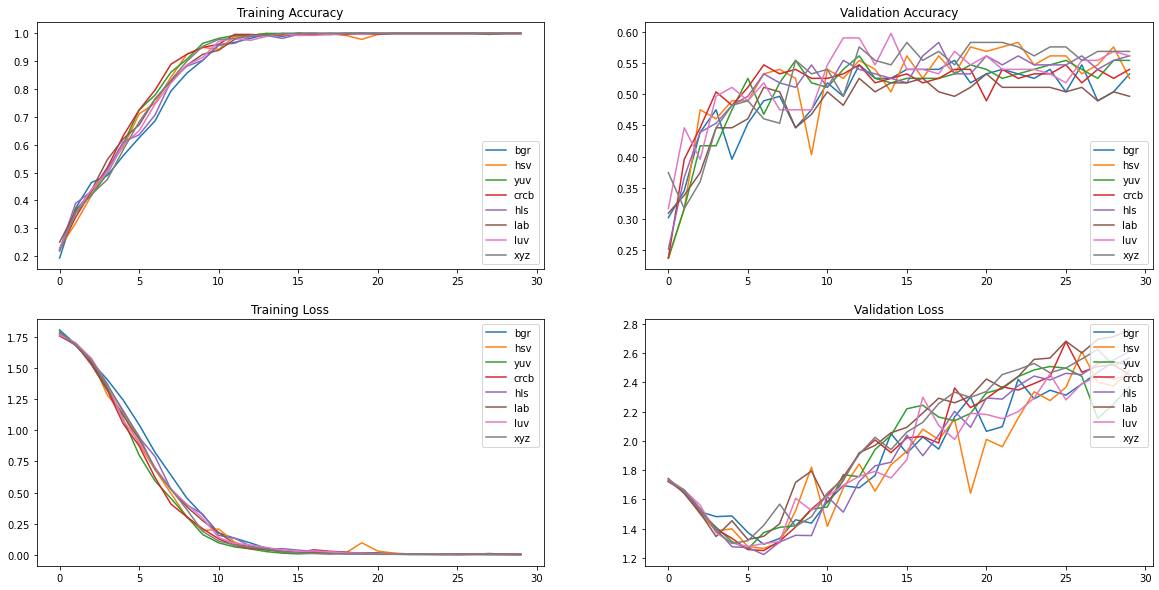

In [53]:
epochs_range = range(30)

plt.figure(figsize = (20, 10))
plt.subplot(2, 2, 1)
for i, c in enumerate(colorspaces):
    plt.plot(epochs_range, history[i].history['accuracy'], label = c)
plt.legend(loc = 'lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
for i, c in enumerate(colorspaces):
    plt.plot(epochs_range, history[i].history['val_accuracy'], label = c)
plt.legend(loc = 'lower right')
plt.title('Validation Accuracy')

plt.subplot(2, 2, 3)
for i, c in enumerate(colorspaces):
    plt.plot(epochs_range, history[i].history['loss'], label = c)
plt.legend(loc = 'upper right')
plt.title('Training Loss')

plt.subplot(2, 2, 4)
for i, c in enumerate(colorspaces):
    plt.plot(epochs_range, history[i].history['val_loss'], label = c)
plt.legend(loc = 'upper right')
plt.title('Validation Loss')
plt.show()

**Goal:** My aim here was not to create a very high-tech state of the art CNN architecture to get the best accuracy but to compare the color spaces. 


**Results:** The results were surprising. I was expecting some color transformations to be more efficient as many images are more about shapes and less about colors. 
Also, I was thinking that the colors in cars are more saturated than that of backgrounds (i.e., trees), and the color space like HSV and HLS might contribute to superior performance. This was not the case.